# [Elo7.dev](elo7.dev) Workshops - GAN School 1

- Implementação do Conditional GAN no dataset MNIST

## Bibliotecas que serão usadas

In [1]:
# Manipulação, transformação e gráficos
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct

# pytorch
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

# Manipulação, transformação e gráficos do pytorch
import torch.utils.data as Data
from torchvision import datasets
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

# Define uma semente fixa para a geração de números aleatórios do pytorch
torch.manual_seed(42)

In [2]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

---
* Funções úteis

In [3]:
def plot_digit(x):
    x = x.cpu().data.numpy().reshape(data_raw.shape[1],data_raw.shape[2])
    plt.imshow(x,cmap='gray_r')
    plt.axis('off')
    plt.show()

def plot_n_random_digits(x,labels=None,n_images=9,title='Digits'):
    """Ate 20 imagens"""
    indices = np.random.choice(x.shape[0],size=n_images)
    x = x[indices].data.numpy()
    if isinstance(labels, torch.IntTensor):
        sample_labels = labels[indices].data.numpy()
    else: sample_labels = ['None']*len(indices)
    x = x.reshape(n_images,data_raw.shape[1],data_raw.shape[2])
    plt.clf()
    plt.style.use('seaborn-muted')
    fig, axes = plt.subplots(2,10, figsize=(12,3), sharex=True, sharey=True,
                             subplot_kw=dict(adjustable='box', aspect='equal'))
    for i in range(n_images):
        subplot_row = i//10
        subplot_col = i%10  
        ax = axes[subplot_row, subplot_col]
        plottable_image = x[i,:]
        ax.imshow(plottable_image, cmap='gray_r')
        if labels != None:
            ax.set_title('Digit Label: {}'.format(sample_labels[i]))
        ax.set_xbound([0,28])
        ax.axis('off')
    plt.show()

    
def print_label(label):
    chosen_label = label
    batch = 20
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    plot_n_random_digits(G(Variable(torch.randn(batch, nz)).to(device),
                         y_sample_tc.type(torch.FloatTensor).to(device)).cpu(),
                         labels=torch.max(y_sample_tc,dim=1)[1].type(torch.IntTensor),
                         n_images=20,title='conditional_gan_generated_{}_{}_'.format(chosen_label,epochs))
    
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.01)  
    
def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()

def plot_losses(losses_his):
    labels = ['Loss: G','Loss: D','Loss: D real','Loss: D fake']
    fig = plt.figure(figsize=(20, 10))
    for i, col in enumerate(labels):
        ax = fig.add_subplot(3, 2, i + 1)
        plt.ylabel(col,fontsize=15)
        plt.plot(losses_his[i])
        ax.grid(True)
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

def noise(n_sample,nz):
    return torch.randn(n_sample, nz).to(device)

def print_losses(G_loss, D_loss, D_loss_real, D_loss_fake):
        print("""D_loss: {:.5f} | G_loss: {:.5f}""".format(D_loss.data, G_loss.data))
        print("""D_real: {:.5f} | D_fake: {:.5f}""".format(D_loss_real.data, D_loss_real.data))

def append_losses(G_loss, D_loss, D_loss_real, D_loss_fake):
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)

def generate_samples(G,n_sample,nz,y_tc):
    z = noise(n_sample,nz)
    g = G(z,y_tc[:n_sample].to(device))
    return g

def nets_test(n_sample,G,D,X_tc,y_tc):
    z = noise(n_sample,nz)
    g = G(z,y_tc[:n_sample].to(device))
    D_real = D(X_tc[:n_sample].to(device),y_tc[:n_sample].to(device))
    D_fake = D(g,y_tc[:n_sample].to(device))
    print('D_real  {:.3f} +- {:.3f}'.format(D_real.mean(),D_real.std()))
    print('D_fake  {:.3f} +- {:.3f}'.format(D_fake.mean(),D_fake.std()))

def label_tensor(size,label):
    chosen_label = label
    batch = size
    y_sample = np.zeros(shape=[batch, y_dim])
    y_sample[:,chosen_label] = 1
    y_sample_tc = torch.Tensor(y_sample).type(torch.IntTensor)
    return y_sample_tc
    
def plots_by_chosen_label(label):
    num_images = 32*3
    y_sample = label_tensor(num_images,label).type(torch.FloatTensor)
    X_fake = generate_samples(G,num_images,nz,y_sample).detach().cpu()
    plt.figure(figsize=(20,7))
    plt.axis("off")
    plt.title(f"Fake Images - label: {i}")
    plt.imshow(np.transpose(vutils.make_grid(X_fake.reshape(num_images,1,28,28).to(device), padding=2, nrow=24, normalize=True).cpu(),(1,2,0)))
    plt.show()

def compare_images():
    real_batch = next(iter(loader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].reshape(mb_size,1,28,28).to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
    plt.show()

In [4]:
# datasets.MNIST('./data', train=True, download=True)
file_images = './data/MNIST/raw/train-images-idx3-ubyte'
file_labels = './data/MNIST/raw/train-labels-idx1-ubyte'

In [5]:
with open(file_images,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data_raw = data_raw.reshape((size, nrows, ncols))

data_raw.shape

(60000, 28, 28)

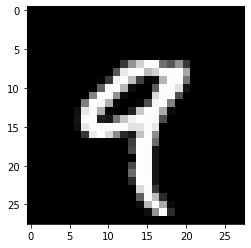

In [6]:
plt.imshow(data_raw[4,:,:], cmap='gray')
plt.show()

In [7]:
data = data_raw.reshape(data_raw.shape[0],data_raw.shape[1]*data_raw.shape[2])
data.shape

(60000, 784)

In [8]:
with open(file_labels,'rb') as f:
    labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

labels = labels[8:]
labels.shape

(60000,)

---

In [9]:
data = MinMaxScaler(feature_range=(-1, 1)).fit_transform(data)
X_tc = torch.Tensor(data).type(torch.FloatTensor)
y_tc = torch.Tensor(np.eye(10)[labels]).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([60000, 784]) torch.FloatTensor torch.Size([60000, 10]) torch.FloatTensor


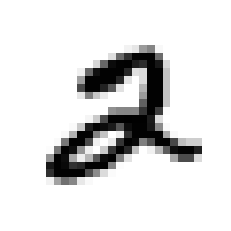

In [10]:
plot_digit(X_tc[5])

<Figure size 432x288 with 0 Axes>

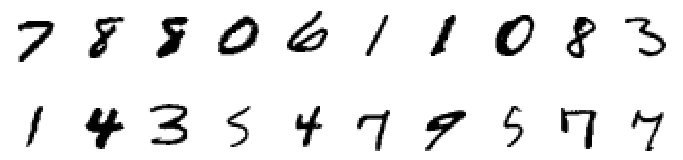

In [11]:
plot_n_random_digits(X_tc,n_images=20)

In [12]:
X_tc.shape

torch.Size([60000, 784])

In [13]:
mb_size = 64
torch_dataset = Data.TensorDataset(X_tc,y_tc)
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = mb_size,
        shuffle=True,
        pin_memory=True,
        num_workers=12
        )

In [14]:
# Dimensões
a_dim,b_dim,c_dim = [784,392,196]
X_dim, y_dim = [X_tc.shape[1],y_tc.shape[1]]
nz = 100
# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(GNet,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(nz+y_dim, a_dim)
        self.hidden2 = torch.nn.Linear(a_dim, b_dim)
        self.hidden3 = torch.nn.Linear(b_dim, c_dim)
        self.hidden4 = torch.nn.Linear(c_dim, b_dim)
        self.hidden5 = torch.nn.Linear(b_dim, a_dim)
        self.out = torch.nn.Linear(a_dim, X_dim)
    
    def forward(self,z,y):
        h = torch.relu(self.hidden1(torch.cat((z,y),dim=1)))
        h = torch.dropout(torch.relu(self.hidden2(h)),p=0.5,train=True)
        h = torch.dropout(torch.relu(self.hidden3(h)),p=0.5,train=True)
        h = torch.dropout(torch.relu(self.hidden4(h)),p=0.5,train=True)
        h = torch.dropout(torch.relu(self.hidden5(h)),p=0.5,train=True)
        h = torch.tanh(self.out(h))
        return h
    
# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self, ngpu):
        super(DNet,self).__init__()
        self.ngpu = ngpu
        self.hidden1 = torch.nn.Linear(X_dim+y_dim, a_dim)
        self.hidden2 = torch.nn.Linear(a_dim, a_dim)
        self.hidden3 = torch.nn.Linear(a_dim, a_dim)
        self.out = torch.nn.Linear(a_dim, 1)
    
    def forward(self,x,y):
        h = F.leaky_relu(self.hidden1(torch.cat((x,y),dim=1)))
        h = torch.dropout(F.leaky_relu(self.hidden2(h)),p=0.5,train=True)
        h = torch.dropout(F.leaky_relu(self.hidden3(h)),p=0.5,train=True)
        y = torch.sigmoid(self.out(h))
        return y

# Instanciamos as redes
G = GNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, list(range(ngpu)))
D = DNet(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
    
#Inicializar pesos das redes
G.apply(init_weights)
D.apply(init_weights)

# Definimos os otimizadores
lrg,lrd = [1e-4,1e-3]
beta = 0.4
G_optim = optim.Adam(G.parameters(), lr=lrg, betas=(beta,0.999))
D_optim = optim.Adam(D.parameters(), lr=lrd, betas=(beta,0.999))

# função de perda
bce_loss = nn.BCELoss()

real_label = 1
fake_label = 0

G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his, D_his, D_real_his, D_fake_his]

fixed_noise = noise(64,nz)
fixed_y = y_tc[:64].to(device)
img_list = []

In [22]:
# #load models
# G.load_state_dict(torch.load('models/g_shapleygan_bigan.pt'))
# F.load_state_dict(torch.load('models/f_shapleygan_bigan.pt'))
# Dx.load_state_dict(torch.load('models/d_shapleygan_bigan.pt'))

In [15]:
%%time
epochs = 50
iters=0

for epoch in range(1,epochs+1):
    # Amostragem de dados
    for i, data in enumerate(loader):
        X = data[0].to(device)
        y = data[1].to(device)
        X_size = X.shape[0]
        ones = torch.full((X_size,), real_label, device=device)
        zeros = torch.full((X_size,), fake_label, device=device)
        
        # D
        z = noise(X_size,nz)
        X_fake = G(z,y)    
        D_real = D(X,y)
        D_fake = D(X_fake,y)
        D_loss_real = bce_loss(D_real.view(-1), ones.view(-1))
        D_loss_fake = bce_loss(D_fake.view(-1), zeros.view(-1))
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optim.step()    
        reset_grad()

        # G
        for j in range(3):
            z = noise(X_size,nz)
            X_fake_ = G(z,y)
            D_fake = D(X_fake_,y)
            G_loss  = bce_loss(D_fake.view(-1), ones.view(-1))
            G_loss.backward(retain_graph=True)
            G_optim.step()
            reset_grad()

        # Recolher dados das funções de perda
        append_losses(G_loss, D_loss, D_loss_real, D_loss_fake)
        
    if (iters % 2 == 0) or ((epoch == epochs-1) and (i == len(loader)-1)):
        with torch.no_grad():
            fake = G(fixed_noise,fixed_y).detach().cpu()
            img_list.append(vutils.make_grid(fake.reshape(64,1,28,28).to(device)[:64], padding=2, normalize=True))
    iters += 1
    
    if epoch % int(epochs/5) == 0 and epoch > 0:
        print('Epoch {}'.format(epoch))
        print_losses(G_loss, D_loss, D_loss_real, D_loss_fake)
        nets_test(20000,G,D,X_tc,y_tc)
        print('-'*40)

Epoch 10
D_loss: 1.30833 | G_loss: 1.03566
D_real: 0.60231 | D_fake: 0.60231
D_real  0.548 +- 0.201
D_fake  0.408 +- 0.151
----------------------------------------
Epoch 20
D_loss: 1.19638 | G_loss: 0.76719
D_real: 0.54215 | D_fake: 0.54215
D_real  0.584 +- 0.170
D_fake  0.474 +- 0.141
----------------------------------------
Epoch 30
D_loss: 1.29405 | G_loss: 0.84998
D_real: 0.78452 | D_fake: 0.78452
D_real  0.584 +- 0.177
D_fake  0.465 +- 0.135
----------------------------------------
Epoch 40
D_loss: 1.23099 | G_loss: 0.89158
D_real: 0.60377 | D_fake: 0.60377
D_real  0.570 +- 0.173
D_fake  0.471 +- 0.126
----------------------------------------
Epoch 50
D_loss: 1.11867 | G_loss: 0.79977
D_real: 0.57792 | D_fake: 0.57792
D_real  0.584 +- 0.202
D_fake  0.447 +- 0.159
----------------------------------------
CPU times: user 11min 47s, sys: 27.5 s, total: 12min 14s
Wall time: 11min 33s


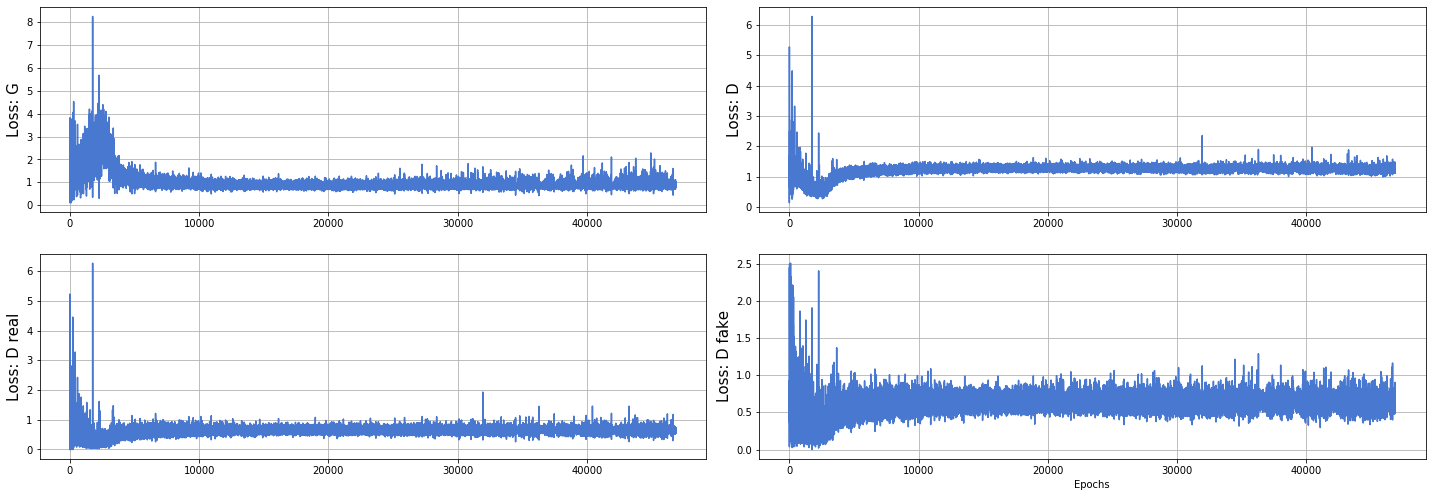

In [16]:
plot_losses(losses_his)

<Figure size 432x288 with 0 Axes>

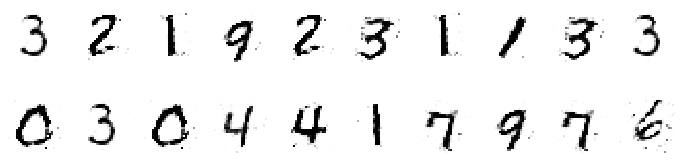

In [17]:
X_fake = generate_samples(G,20,nz,y_tc)
plot_n_random_digits(X_fake.cpu(),labels=None,n_images=20,title='Digits')

<Figure size 432x288 with 0 Axes>

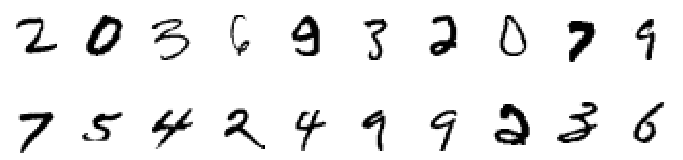

In [27]:
plot_n_random_digits(X_tc,n_images=20)

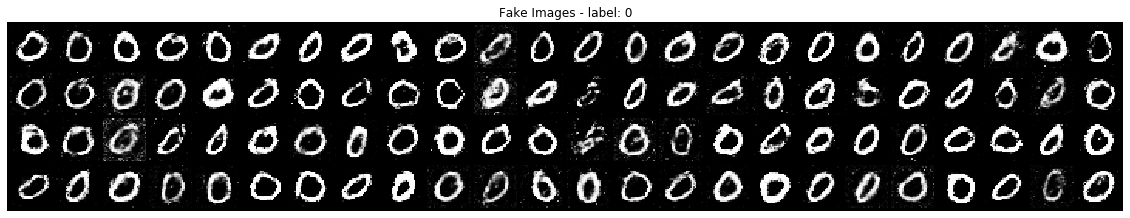

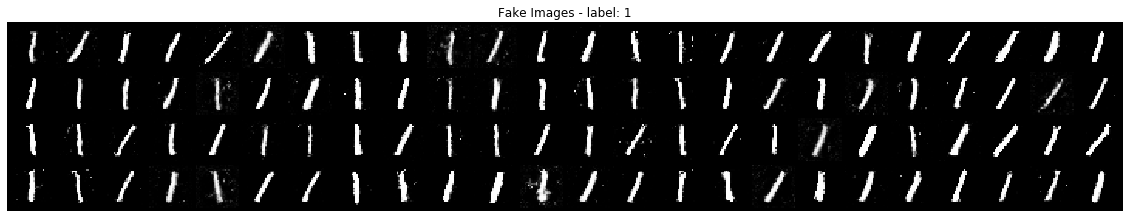

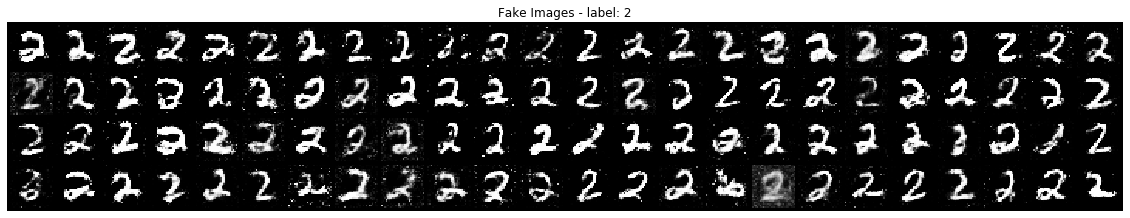

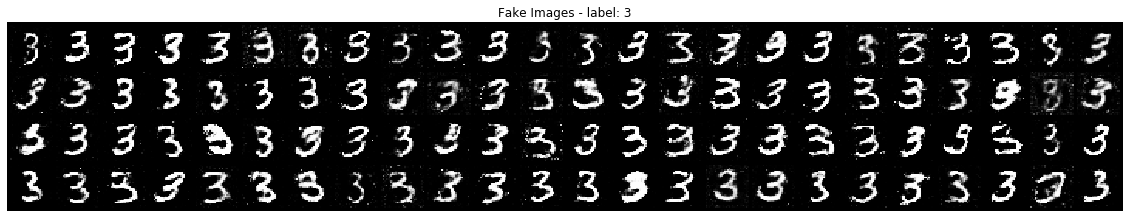

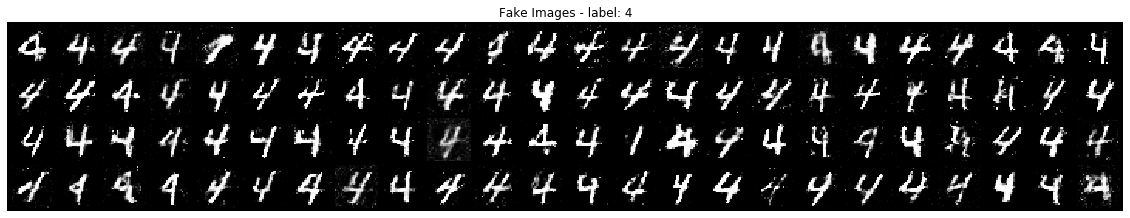

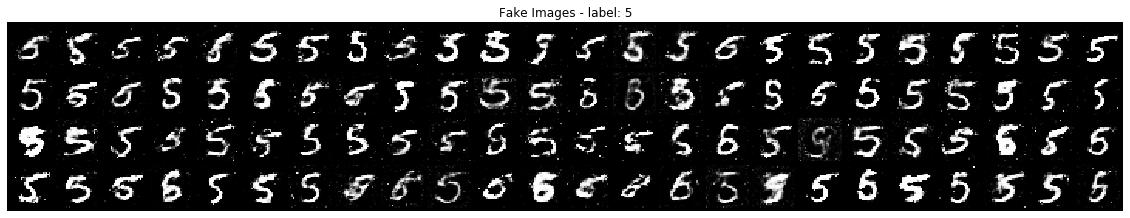

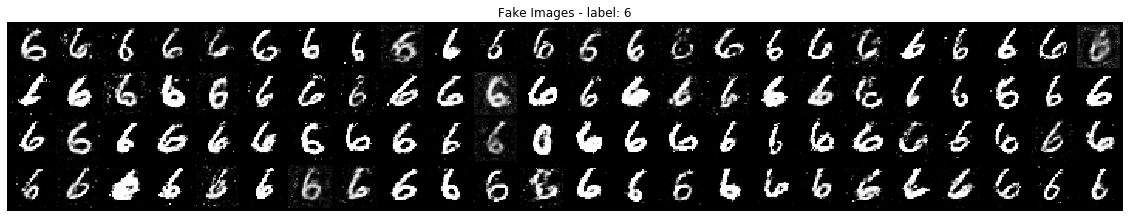

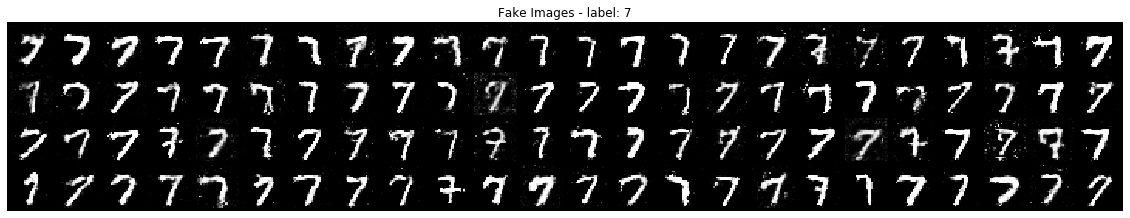

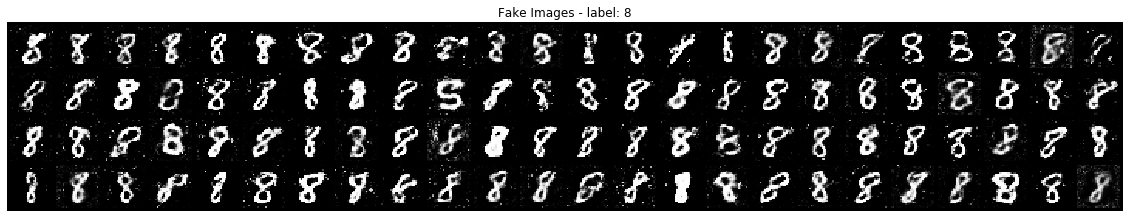

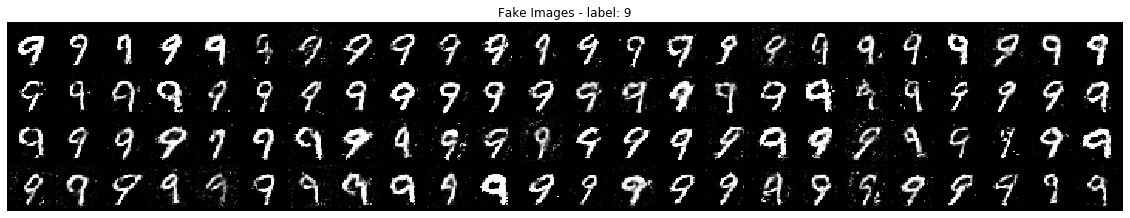

In [18]:
for i in range(10):
    plots_by_chosen_label(i)

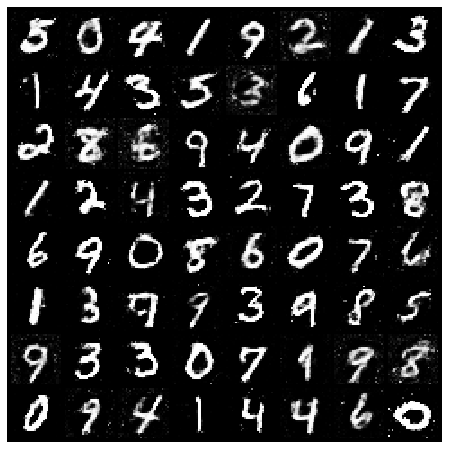

In [19]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

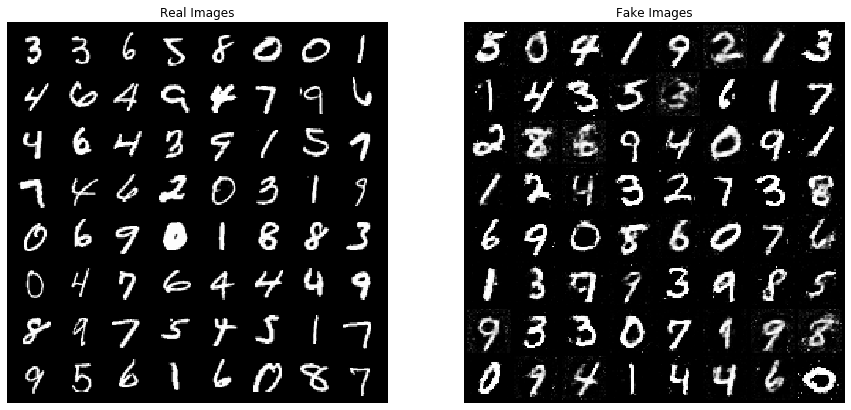

In [20]:
compare_images()

## Não gostou dos resultados?

GANs são difíceis de treinar e cada conjunto de dados pode precisar de ajustes únicos, mas aqui estão algumas dicas que costumam melhorar o desempenho do treino da sua GAN:
- Escale os valores de X entre (-1,1) ou (0,1). Assim você pode usar uma Tanh ou Sigmoid, respectivamente, na saída do gerador.
- Tente usar uma arquitetura de autoencoder no Gerador.
- Tente ativações leaky relu tanto no Gerador quanto no Discriminador.
- Adicione ruído na forma de dropout apenas no Gerador.
- Não use ruído uniforme, tente uma gaussiana.
- Treine o Discriminador mais vezes que o Gerador.
- Treine o Gerador mais vezes que o Discriminador.
- Treine o discriminador com mini-batches de apenas imagens reais e depois com apenas imagens falsas.
- Se parece que está perto de um resultado de qualidade tente ir aumentando o tamanho de suas redes aos poucos.
- Construa o discriminador para que ele também seja um classificador de imagens.